# Задание 4: Подбор параметров динамической системы методом MCMC 

Требуется найти параметры системы Хищник-Жертва (Модель Лотки — Вольтерры) при помощи метода MCMC. 

Результатом является записная книжка Python Notebook в которой: 

1) Задаются параметры системы Хищник-Жертва 
2) Решается прямая задача и генерируются данные 
3) К данными применяется зашумление 
4) Методом MCMC оцениваются параметры системы по зашумленным данным 

Возможно использования пакета РуMC или любого другого. 

При решении задачи имеет смысл взять один из параметров равным 1. 

In [15]:
#подключаем требуемую библиотеку
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

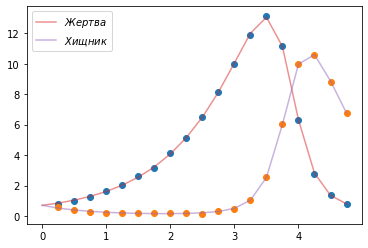

In [16]:
def PredatorPrey(y, t, p):
    #x, y = vec
    dx = (p[0] - p[1]*y[1])*y[0]
    dy = (-p[2] + p[3]*y[0])*y[1]
    return [dx, dy]


times = np.arange(0, 5, 0.25)

alpha = 1.0
beta = 0.4
gamma = 1.5
delta = 0.4

# создаём кривые 
y = odeint(PredatorPrey,  y0=[0.7, 0.7], t=times,args=((alpha, beta, gamma, delta),), rtol=1e-8)

yobs = np.clip(np.random.normal(loc = y[1::], scale = 0.05), a_min = 0, a_max = None)

plt.plot(times[1::], yobs, marker="o", linestyle="none")
plt.plot(times, y[:, 0], color="C3", alpha=0.5, label=f"$Жертва$")
plt.plot(times, y[:, 1], color="C4", alpha=0.5, label=f"$Хищник$")
plt.legend()
plt.show()

In [17]:
PredatorPrey_model = DifferentialEquation(
    func=PredatorPrey,
    
    # начальная точка не включена
    times=np.arange(0.25, 5, 0.25),
    
    # выберем размерность нашей системы ОДУ
    n_states=2, 
    
    # размерность вектора наших параметров
    n_theta=4,  
    t0=0,
)

In [18]:
with pm.Model() as model4:
    sigma = pm.HalfCauchy("sigma", 1, shape=2)
    
    # пусть величины распределены равномерно
    alpha = pm.Uniform("alpha", 0.1, 1.0)
    beta = pm.Uniform("beta", 0.1, 1.0)
    gamma = pm.Uniform("gamma", 0.1, 1.0)
    delta = pm.Uniform("delta", 0.1, 1.0)
    
    # решение ОДУ
    PredatorPrey_curves = PredatorPrey_model(y0=[0.5, 0.5], theta=[alpha, beta, gamma, delta])

    Y = pm.Normal("Y", mu=PredatorPrey_curves, sigma=sigma, observed=yobs)

    # trace - след отобранной точки
    trace = pm.sample(80, tune=40, target_accept=0.9, cores=1) 
    data = az.from_pymc3(trace=trace)

<ipython-input-18-d880e2a64a5e>:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(80, tune=40, target_accept=0.9, cores=1)
Only 80 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\viole\anaconda3\lib\site-packages\aesara\tensor\elemwise.py:791: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\viole\anaconda3\lib\site-packages\aesara\graph\fg.py:525: UserWarning: Variable Elemwise{mul,no_inplace}.0 cannot be replaced; it isn't in the FunctionGraph
  warnings.warn(
Sequential sampling (2 chains in 1 job)
NUTS: [delta, gamma, beta, alpha, sigma]


Sampling 2 chains for 40 tune and 80 draw iterations (80 + 160 draws total) took 2296 seconds.
C:\Users\viole\anaconda3\lib\site-packages\pymc3\sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


array([[<AxesSubplot:title={'center':'sigma\n0'}>,
        <AxesSubplot:title={'center':'sigma\n1'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'delta'}>]], dtype=object)

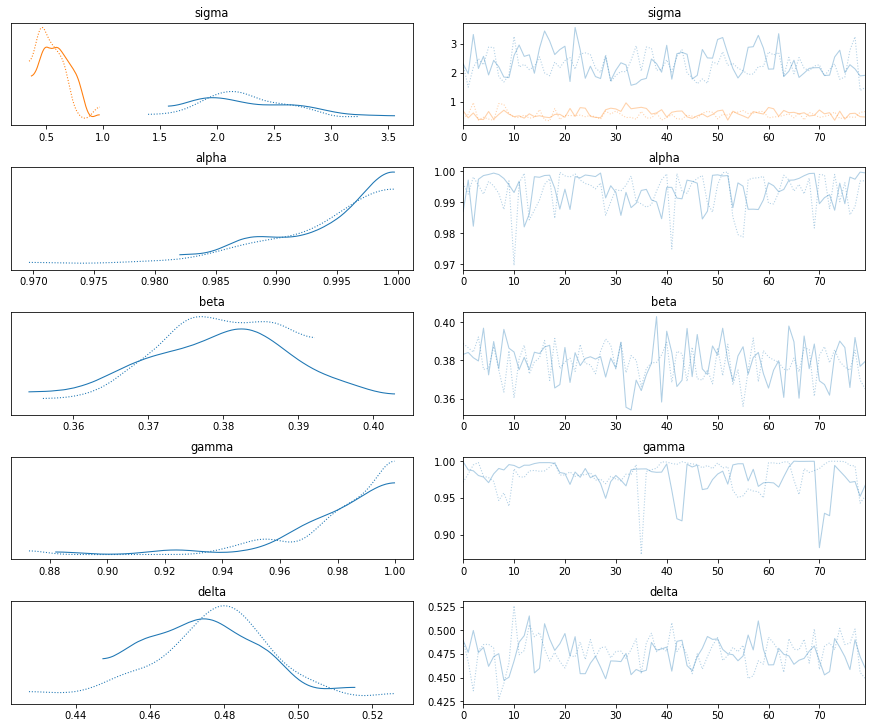

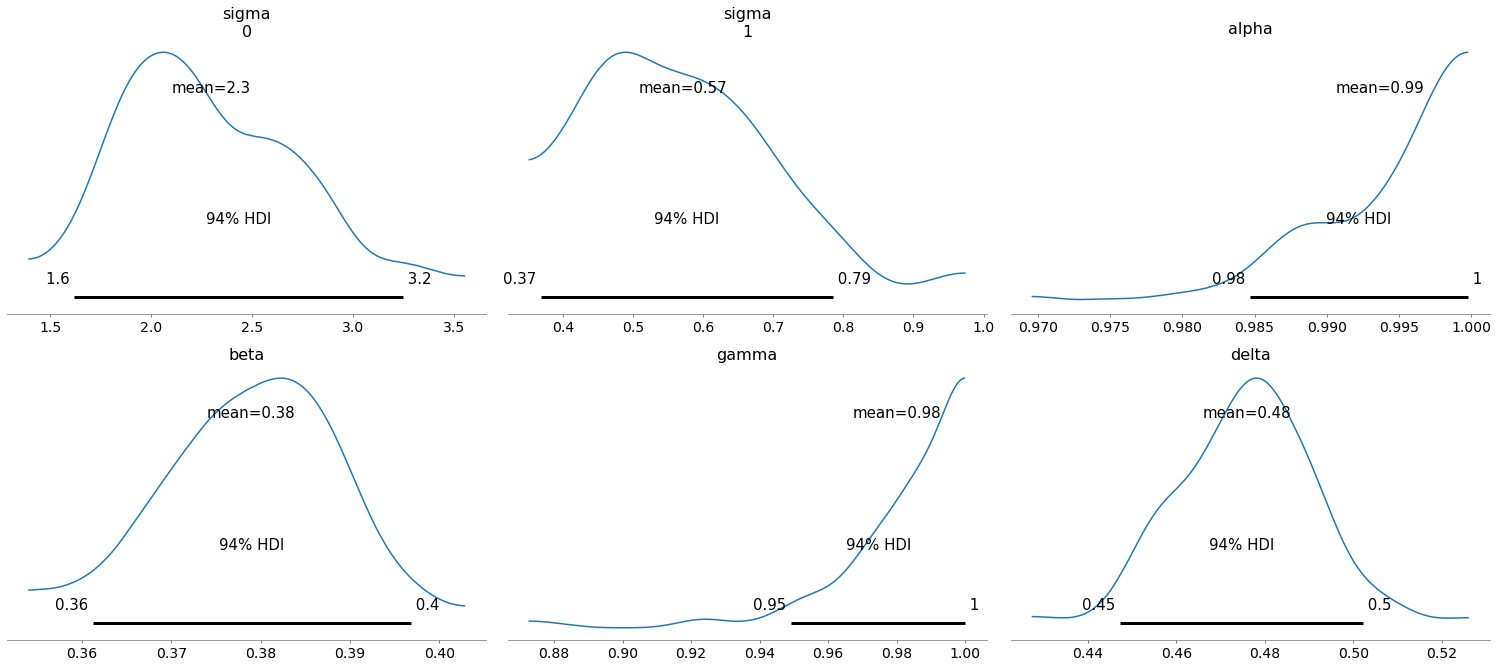

In [19]:
with model4:
    az.plot_trace(trace)
    
# до этого мы выбрали точки и теперь можем наблюдать изменение параметров
az.plot_posterior(data, round_to=2)

# оценка параметров в зависимости от данных
# получим распределение на графиках ниже